# pyvista 3D visulization

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import os 

_dir = 'spinodal_model'

# mesh = pv.read('spinodal_model1/0.8353981633974482_0.1_0.1_5.stl')
for roots, dirs, files in os.walk(_dir):
    for file in files:
        if file.endswith('.stl') and file[0] != '.':
            mesh_file = os.path.join(roots, file)
            mesh= pv.read(mesh_file)
            # Create a plotter object
            plotter = pv.Plotter()

            # Add the mesh to the plotter
            plotter.add_mesh(mesh, color="#FABf7b", specular=0.01,specular_power=0.2, smooth_shading=True, show_edges=True, edge_color=[50,50,50])

            # Set the view angle
            plotter.view_vector((10, -10, 10), (0, 0, 0))

            # Enable light
            plotter.enable_lighting = True
            # Create a light and add it to the plotter
            light = pv.Light(position=(100, 10, 10), focal_point=(0, 0, 0), light_type='cameralight')
            plotter.add_light(light)

            plotter.view_vector((8, 10, 15), (5, 0, 0))
            # Show the plot
            plotter.set_background((255,255,255))

            # Enable depth peeling
            plotter.enable_depth_peeling()

            # plotter.show(window_size=(2400, 2400))
            # mesh.plot(show_edges=True, color='tan')

            plotter.save_graphic(mesh_file[:-4] + '.model.svg')


# triangular plot

In [7]:
# plot analysis 
import plotly.graph_objects as go
import numpy as np
import src.plot_layout as plot_layout
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = "browser"
layout = plot_layout.layout
import os
import pyvista as pv

# file_name ='spinodal_model/0.0_0.0_0.6_10.stl.stl'
layout['width'] = 1200
layout['height'] = 1200

_dir = 'spinodal_model'
for roots, dirs, files in os.walk(_dir):
    for file in files:
        if file.endswith('.stl') and file[0] != '.':
            file_name = os.path.join(roots, file)


            mesh = pv.read(file_name)
            points= mesh.points
            cells = mesh.faces.reshape(-1, 4)[:,1:]#numpts, x,y,z
            edges = []
            for i,j,k in cells:
                edges.append([i,j] if i<j else [j,i])
                edges.append([j,k] if j<k else [k,j])
                edges.append([k,i] if k<i else [i,k])
            edges = np.unique(edges, axis=0)

            edge_lens = np.array([np.sqrt(np.sum((points[i]-points[j])**2)) for i,j in edges])
            face_angle_nonnorm = np.array([np.cross(points[i]-points[j],points[i]-points[k]) for i,j,k in cells]) # face angle non normalized
            face_angle = np.array([np.cross(points[i]-points[j],points[i]-points[k])/np.linalg.norm(np.cross(points[i]-points[j],points[i]-points[k])) for i,j,k in cells])
            theta = np.array([[np.arccos(x),np.arccos(y),np.arccos(z)] for x,y,z in face_angle])
            face_angle_abs = np.abs(face_angle)


            
            x=face_angle[:,0]
            y=face_angle[:,1]
            z=face_angle[:,2]
            from scipy.stats import gaussian_kde
            # Perform KDE to estimate density
            xyz = np.vstack([x,y,z])
            kde = gaussian_kde(xyz)
            density = kde(xyz)

            # Create the 3D scatter plot
            fig = go.Figure(data=go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=6, color=density, colorscale='Jet')))
            # show color bar 
            fig.update_layout(layout)
            fig.update_layout(scene=dict(xaxis_title='<b>X</b>',
                                        yaxis_title='<b>Y</b>',
                                        zaxis_title='<b>Z</b>'))
            fig.update_layout(
                scene=dict(
                    xaxis=dict(showgrid=False, zeroline=False, linewidth=2, linecolor='black',backgroundcolor='white',ticklen=5,tickwidth=5,tickprefix='<b>',ticksuffix='</b>',
                               title=dict(text='<b>X</b>',font=dict(family = 'Times New Roman',size=20,color='black'))),
                    yaxis=dict(showgrid=False, zeroline=False, linewidth=2, linecolor='black',backgroundcolor='white',ticklen=5,tickwidth=5,tickprefix='<b>',ticksuffix='</b>',title=dict(text='<b>Y</b>',font=dict(size=20,color='black'))),
                    zaxis=dict(showgrid=False, zeroline=False, linewidth=2, linecolor='black',backgroundcolor='white',ticklen=5,tickwidth=5,tickprefix='<b>',ticksuffix='</b>',title=dict(text='<b>Z</b>',font=dict(size=20,color='black'))),
                    bgcolor='#ffffff',
                    aspectmode='cube',  # this will make the axes scales equal
                    camera=dict(
                        eye=dict(x=2, y=2, z=0.5)  # adjust these values to change the view angle
                    ),
                ),
                
                paper_bgcolor='white',  # Background color of the entire plot area
                plot_bgcolor='white'  # Also set the plot background color to white

            )
            fig.write_image(file_name[:-4] + '.sph.png')
            # fig.show()
            
            fig = ff.create_ternary_contour(np.array([x**2, y**2, z**2]), density,
                                pole_labels=['<b>X</b>', '<b>Y</b>', '<b>Z</b>'],
                                interp_mode='cartesian',
                                colorscale='Jet',
                                )
            fig.update_layout(plot_layout.layout)
            fig.update_ternaries(aaxis= {'linewidth': 5,'nticks':5, 'min': 0.01, 'ticks': 'outside', 'title': {'text':'<b>X</b>','font':dict(size=70)},'tickfont':dict(size=50),"tickprefix":'<b>'},
                                    baxis= {'linewidth': 5,'nticks':5, 'min': 0.01, 'ticks': 'outside', 'title': {'text':'<b>Y</b>','font':dict(size=70)},'tickfont':dict(size=50),"tickprefix":'<b>'},
                                    caxis= {'linewidth': 5,'nticks':5, 'min': 0.01, 'ticks': 'outside', 'title': {'text':'<b>Z</b>','font':dict(size=70)},'tickfont':dict(size=50),"tickprefix":'<b>'})
            # import  src.plot_layout as plot_layout
            layout = plot_layout.layout
            layout['showlegend'] = False
            fig.write_image(file_name[:-4] + '.ternarycontour.png')
            fig.show()
            x= face_angle_abs[:,0]
            y= face_angle_abs[:,1]
            z= face_angle_abs[:,2]
            fig = go.Figure(data=go.Scatterternary(a=x, b=y, c=z,mode='markers', marker=dict(size=7, color=density, colorscale='Jet')))
            fig.update_layout(layout)
            fig.update_ternaries(aaxis= {'linewidth': 5, 'min': 0.01, 'ticks': 'outside', 'title': {'text':'<b>X</b>','font':dict(size=70)},'tickfont':dict(size=50),"tickprefix":'<b>','nticks':5},
                                    baxis= {'linewidth': 5, 'min': 0.01, 'ticks': 'outside', 'title': {'text':'<b>Y</b>','font':dict(size=70)},'tickfont':dict(size=50),"tickprefix":'<b>','nticks':5},
                                    caxis= {'linewidth': 5, 'min': 0.01, 'ticks': 'outside', 'title': {'text':'<b>Z</b>','font':dict(size=70)},'tickfont':dict(size=50),"tickprefix":'<b>','nticks':5})
            # fig.show()
            layout['showlegend'] = False
            fig.write_image(file_name[:-4] + '.ternaryscatter.png')
            # fig.write_image('test.ternaryscatter.png')
            # fig.show()
            # # print(x)
            break

Error: could not locate runnable browser

# test _ 

In [ ]:
fig.update_layout(plot_layout.layout)
fig.update_layout(scene=dict(xaxis_title='<b>X</b>',
                             yaxis_title='<b>Y</b>',
                             zaxis_title='<b>Z</b>'))
fig.update_layout(
    scene=dict(
        xaxis=dict(showgrid=False, zeroline=False, linewidth=2, linecolor='black',backgroundcolor='white',ticklen=5,tickwidth=5,tickprefix='<b>',ticksuffix='</b>',title=dict(text='<b>X</b>',font=dict(size=20,color='black'))),
        yaxis=dict(showgrid=False, zeroline=False, linewidth=2, linecolor='black',backgroundcolor='white',ticklen=5,tickwidth=5,tickprefix='<b>',ticksuffix='</b>',title=dict(text='<b>X</b>',font=dict(size=20,color='black'))),
        zaxis=dict(showgrid=False, zeroline=False, linewidth=2, linecolor='black',backgroundcolor='white',ticklen=5,tickwidth=5,tickprefix='<b>',ticksuffix='</b>',title=dict(text='<b>X</b>',font=dict(size=20,color='black'))),
        bgcolor='#ffffff',
        aspectmode='cube',  # this will make the axes scales equal
        camera=dict(
            eye=dict(x=2, y=2, z=0.5)  # adjust these values to change the view angle
        ),
    ),
    
    paper_bgcolor='white',  # Background color of the entire plot area
    plot_bgcolor='white'  # Also set the plot background color to white

)

fig.show()


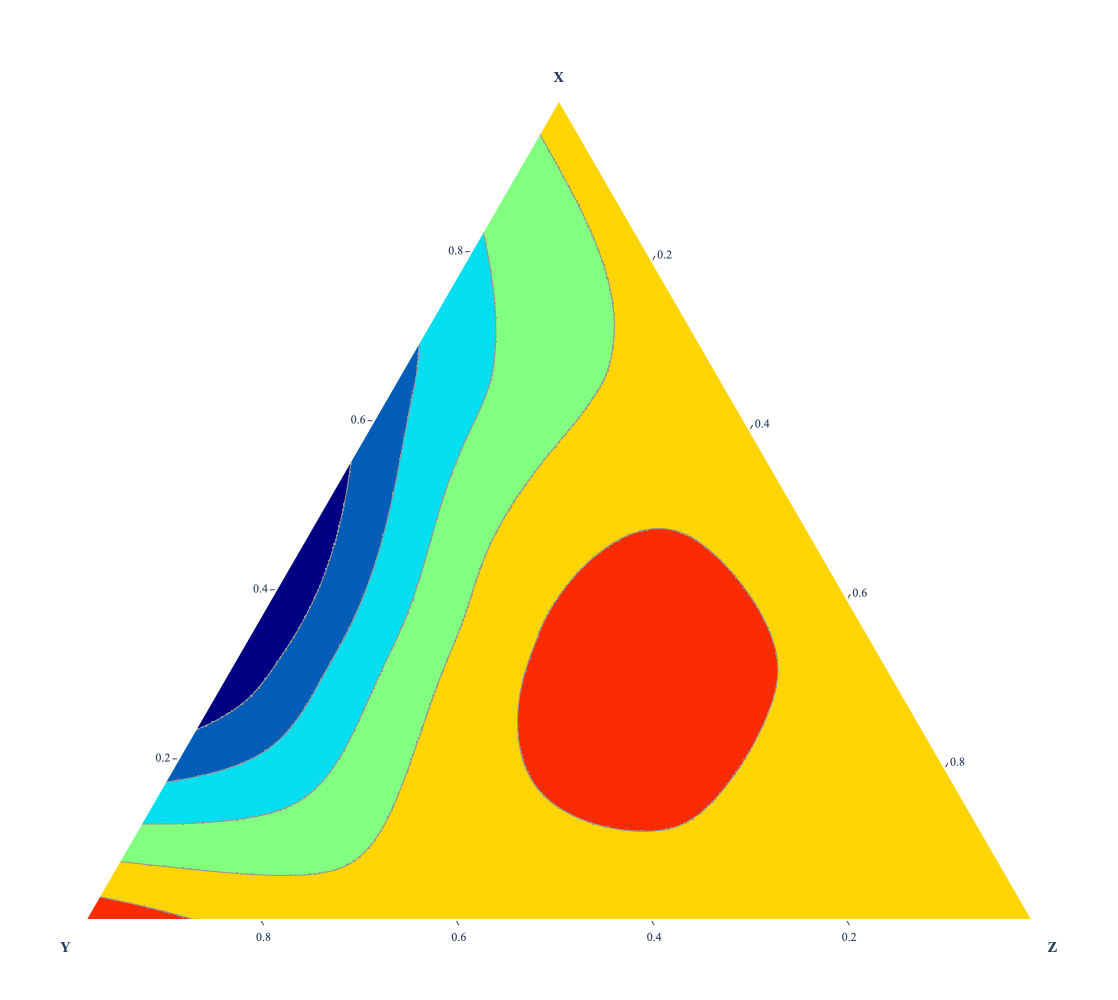

In [3]:
import plotly.figure_factory as ff
import numpy as np
Al = np.array([0. , 0. , 0., 0., 1./3, 1./3, 1./3, 2./3, 2./3, 1.])
Cu = np.array([0., 1./3, 2./3, 1., 0., 1./3, 2./3, 0., 1./3, 0.])
Y = 1 - Al - Cu
# synthetic data for mixing enthalpy
# See https://pycalphad.org/docs/latest/examples/TernaryExamples.html
enthalpy = (Al - 0.01) * Cu * (Al - 0.52) * (Cu - 0.48) * (Y - 1)**2
fig = ff.create_ternary_contour(np.array([Al, Cu, Y]), enthalpy,
                                pole_labels=['<b>X</b>', '<b>Y</b>', '<b>Z</b>'],
                                interp_mode='cartesian',
                                colorscale='Jet',
                                )

import  src.plot_layout as plot_layout
layout = plot_layout.layout
layout['showlegend'] = False
fig.update_layout(plot_layout.layout)
fig.show()

In [ ]:
# print(fig)
fig.update_ternaries(aaxis= {'linewidth': 5, 'min': 0.01, 'ticks': 'outside', 'title': {'font':dict(size=25)},'tickfont':dict(size=20),"tickprefix":'<b>'},
                           baxis= {'linewidth': 5, 'min': 0.01, 'ticks': 'outside', 'title': {'font':dict(size=25)},'tickfont':dict(size=20),"tickprefix":'<b>'},
                           caxis= {'linewidth': 5, 'min': 0.01, 'ticks': 'outside', 'title': {'font':dict(size=25)},'tickfont':dict(size=20),"tickprefix":'<b>'},
                           )
fig.show()

In [ ]:
print(fig)

In [ ]:
fig = go.Figure(data=go.Scatterternary(a=x, b=y, c=z,mode='markers', marker=dict(size=7, color=density, colorscale='Jet')))
# print(fig)
fig.update_layout(plot_layout.layout)
fig.update_ternaries(aaxis= {'linewidth': 5, 'min': 0.01, 'ticks': 'outside', 'title': {'text':'<b>X</b>','font':dict(size=25)},'tickfont':dict(size=20),"tickprefix":'<b>'},
                           baxis= {'linewidth': 5, 'min': 0.01, 'ticks': 'outside', 'title': {'text':'<b>Y</b>','font':dict(size=25)},'tickfont':dict(size=20),"tickprefix":'<b>'},
                           caxis= {'linewidth': 5, 'min': 0.01, 'ticks': 'outside', 'title': {'text':'<b>Z</b>','font':dict(size=25)},'tickfont':dict(size=20),"tickprefix":'<b>'})
fig.show()

In [ ]:
import os 
for roots,dirs,files in os.walk('spinodal_model'):
    for file in files:
        if file[-3:] =='stl':
            name = file.split('_')
            name = f'{float(name[0]):.1f}_{float(name[1]):.1f}_{float(name[2]):.1f}_{name[3]}.stl'
            os.rename(os.path.join(roots,file),os.path.join(roots,name))
            
            

In [ ]:
from scipy.stats import gaussian_kde
import plotly.graph_objects as go
import numpy as np

# Suppose x, y, z are your 3D vector components
x = np.random.randn(1000)  # replace with your data
y = np.random.randn(1000)  # replace with your data
z = np.random.randn(1000)  # replace with your data
x,y,z= np.array([x,y,z])/np.linalg.norm(np.array([x,y,z]),axis=0)
# Perform KDE to estimate density
xyz = np.vstack([x,y,z])
kde = gaussian_kde(xyz)
density = kde(xyz)

# Create the 3D scatter plot
fig = go.Figure(data=go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=6, color=density, colorscale='Viridis')))
fig.show()



In [ ]:
import numpy as np
from scipy.interpolate import griddata
import plotly.express as px
import plotly.graph_objects as go
# Define the grid where we want to interpolate
x=face_angle[:,0]
y=face_angle[:,1]
z=face_angle[:,2]
grid_x, grid_y = np.mgrid[-1:1:100j, -1:1:100j]

# Interpolate using scipy's griddata function
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

# Create the surface plot using plotly
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z)])
fig.show()
px.histogram(x).show()
px.histogram(y).show()
px.histogram(z).show()

In [ ]:
import plotly.express as px
fig = px.histogram(x=edge_lens, nbins=100)
# fig = go.Figure(data=[hist])
fig.show()

# 3D model out

In [ ]:
from src import agent
import numpy as np
import matplotlib.pyplot as plt
import pyacvd
import pyvista as pv
import numpy as np
from numba import jit
import meshio
import os

# @jit
def Model(_m):
    n=200
    ratio = 0.1
    num = int(n*(1+2*ratio)+1)
    off = int(n*ratio)
    
    x = np.linspace(-10,110,num)
    y = np.linspace(-10,110,num)
    z = np.linspace(-10,110,num)
    size = 100
    
    grid = pv.ImageData(
        dimensions=(num, num, num),
        spacing=(0.5, 0.5, 0.5),
        origin=(-10, -10, -10),
    )
    
    xx,yy,zz = np.meshgrid(x,y,z)
    outer = np.zeros(shape=(num,num,num))
    spin = agent.Spinodal(a=1,b=1,c=1,t_1=0.2,t_2=0.2,t_3=0.2,beta=2*_m*np.pi/size)

    # for i_ in range(n):
    #     for j_ in range(n):
    #         for k_ in range(n):
    #             i = int(i_+off)
    #             j = int(j_+off)
    #             k = int(k_+off)
    #             value[i,j,k] = spin([xx[i,j,k],yy[i,j,k],zz[i,j,k]])
    
    value = np.array([[[spin([xx[i+off,j+off,k+off],yy[i+off,j+off,k+off],zz[i+off,j+off,k+off]]) for i in range(n)] for j in range(n)] for k in range(n)])
    
    return value,grid,outer,off
                

for m in range(1,6):
    print(m)
    voxel,grid,outer,off  = Model(m)

    vox_p = np.where(voxel>0, 1, 0)
    vox_m = np.where(voxel<0, 1, 0)
    grid_pv = np.zeros(outer.shape)
    grid_pv[off:-off-1,off:-off-1,off:-off-1] = vox_p
    value_p = grid_pv.flatten()
    grid_mv = np.zeros(outer.shape)
    grid_mv[off:-off-1,off:-off-1,off:-off-1] = vox_m
    value_m = grid_mv.flatten()



    dir_ = "3dModel"
    mesh1 = grid.contour([1], value_p, method='marching_cubes')
    # dist1 = np.linalg.norm(mesh1.points, axis=1)
    # mesh1 = mesh1.triangulate()
    pv.save_meshio(os.path.join(dir_,f"mesh_{2*m}_1.stl"), mesh1)
    mesh0 = grid.contour([1], value_m, method='marching_cubes')
    # dist0 = np.linalg.norm(mesh0.points, axis=1)
    # mesh0 = mesh0.triangulate()
    pv.save_meshio(os.path.join(dir_,f"mesh_{2*m}_0.stl"), mesh0)


In [1]:
# turbulance model

from src import agent
import numpy as np
import matplotlib.pyplot as plt
import pyacvd
import pyvista as pv
import numpy as np
from numba import jit
import meshio
import os

n=50
ratio = 0.1
num = int(n*(1+2*ratio)+1)
off = int(n*ratio)

x = np.linspace(-10,110,num)
y = np.linspace(-10,110,num)
z = np.linspace(-10,110,num)
size = 100

grid = pv.ImageData(
    dimensions=(num, num, num),
    spacing=(0.5, 0.5, 0.5),
    origin=(-10, -10, -10),
)

xx,yy,zz = np.meshgrid(x,y,z)
outer = np.zeros(shape=(num,num,num))



value = np.array([[[int(np.random.rand()*2-1) for i in range(n)] for j in range(n)] for k in range(n)])


voxel,grid,outer,off  =value,grid,outer,off

vox_p = np.where(voxel>0, 1, 0)
vox_m = np.where(voxel<0, 1, 0)
grid_pv = np.zeros(outer.shape)
grid_pv[off:-off-1,off:-off-1,off:-off-1] = vox_p
value_p = grid_pv.flatten()
grid_mv = np.zeros(outer.shape)
grid_mv[off:-off-1,off:-off-1,off:-off-1] = vox_m
value_m = grid_mv.flatten()

from stl import mesh
from skimage import measure
verts, faces, normals, values = measure.marching_cubes(vox_p, level=0.1)
# Create a mesh object
solid_mesh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
for i, f in enumerate(faces):
    for j in range(3):
        solid_mesh.vectors[i][j] = verts[f[j],:]
        
solid_mesh.save('solid.stl')

verts, faces, normals, values = measure.marching_cubes(vox_m, level=0.1)
# Create a mesh object
solid_mesh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
for i, f in enumerate(faces):
    for j in range(3):
        solid_mesh.vectors[i][j] = verts[f[j],:]
        
solid_mesh.save('solid1.stl')

# dir_ = "3dModel"
# mesh1 = grid.contour([1], value_p, method='marching_cubes')
# # dist1 = np.linalg.norm(mesh1.points, axis=1)
# mesh1 = mesh1.triangulate()
# pv.save_meshio(os.path.join(dir_,f"turbu_1.stl"), mesh1)
# mesh0 = grid.contour([1], value_m, method='marching_cubes')
# # dist0 = np.linalg.norm(mesh0.points, axis=1)
# mesh0 = mesh0.triangulate()
# pv.save_meshio(os.path.join(dir_,f"turbu_0.stl"), mesh0)

ValueError: Surface level must be within volume data range.

## another method

In [ ]:
from stl import mesh
from skimage import measure


verts, faces, normals, values = measure.marching_cubes(voxel, level=0.5)
# Create a mesh object
solid_mesh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
for i, f in enumerate(faces):
    for j in range(3):
        solid_mesh.vectors[i][j] = verts[f[j],:]
        
solid_mesh.save('solid.stl')

